# Preparation

## Imports

In [1]:
# TensorFlow
import tensorflow as tf
import tensorboard as tb
# Data handling
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
# Other stuff
import itertools
import datetime
import time
import pickle
import functools
import json
import sys
import os
import shutil

## Paths

In [2]:
# Base path for functions
base_path = "C:/repos/"
sys.path.append(base_path)

# Path where configs are stored
configs_path = base_path + "twrds_unbiased_anns/configs/"

# Path top store runs
runs_path = base_path + "twrds_unbiased_anns/runs/"

# Path to store run results
results_path = base_path + "twrds_unbiased_anns/runs/results/"

## Functions

In [3]:
# Import of functions
# Sample creation
from twrds_unbiased_anns.src.data.samples import create_sample_array, get_sample_data, get_sample_params, convert_sample_to_np_array, gen_from_sample, dataset_from_gen
# Evaluation
from twrds_unbiased_anns.src.data.eval import load_eval_samples, evaluate_performance, evaluate_model, store_results
# Models
from twrds_unbiased_anns.src.tf.models import get_model
# Losses
from twrds_unbiased_anns.src.tf.losses import get_loss
# Optimizers
from twrds_unbiased_anns.src.tf.optimizers import get_optimizer
# Utils
from twrds_unbiased_anns.src.utils import load_config_from_file, mkdir, rmdir

# Config

In [4]:
# Set name for this run
run_name = "regression_model_distractor" # Also name of the config file

# Set run directory
run_dir = runs_path + run_name

# Get current date
cur_date = datetime.datetime.today()
date_str = cur_date.strftime("%d-%m-%Y")

# Load all variables from config file
config_filename = run_name + ".json"
name, eval_sample_filename, dataset_size, colors, optimizer, repeats_per_model, batch_size, n_epochs, mean_diffs, stddevs, minority_shares, categorical, models, loss_functions = load_config_from_file(configs_path + config_filename)

# Create directory for this run
mkdir(run_dir, delete = False)

# Create logdir
log_base_dir = run_dir + "/logs/"
mkdir(log_base_dir, delete = False)

# Training

## TensorBoard Setup

In [6]:
# Delete tensorboard temp dir
#rmdir("C:/Users/lucas/AppData/Local/Temp/.tensorboard-info")
# Load Tensorboard
%reload_ext tensorboard
%tensorboard --logdir $log_base_dir

Reusing TensorBoard on port 6006 (pid 9060), started 0:01:26 ago. (Use '!kill 9060' to kill it.)

In [7]:
# Create empty list of all results
results = []

# Load evaluation sample
eval_samples = load_eval_samples(base_path + "twrds_unbiased_anns/data/eval/" + eval_sample_filename)

# Calculate number of steps per epoch
n_steps = int(dataset_size/batch_size)

# Store last m_diff
recent_m_diff = 0

# Iterate over all variable parameter combinations
for (modelname, lossname, category, m_diff, std, share) in itertools.product(models, loss_functions, categorical, mean_diffs, stddevs, minority_shares):
   
    # Get name of current iteration
    cur_name = name.format(modelname, lossname, category, m_diff, std, share)

    # Clear session once and then every time before a new model is trained
    tf.keras.backend.clear_session()

    # Get sample parameters
    white_square, white_circle, colorful_square, colorful_circle = get_sample_params(category, m_diff, std, share)

    # Prepare and save sample
    train_sample = create_sample_array(dataset_size, white_square, white_circle, colorful_square, colorful_circle)
    sample_filename = run_dir + "/" + "sample_{}_{}".format(cur_name, date_str)
    np.save(file = sample_filename, arr = train_sample)

    # Create dataset from training data sample
    data = dataset_from_gen(train_sample, n_epochs, batch_size, colors) 

    # Loop training for number of repeats
    for repeat in range(1, repeats_per_model + 1):   

        # Clear keras session
        tf.keras.backend.clear_session()

        # Create model and compile it
        model = get_model(modelname)
        model.compile(optimizer = get_optimizer(optimizer), loss = get_loss(lossname))  

        # Create logdir and callback
        logdir = log_base_dir + cur_name + "_" + str(repeat)
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

        # Do training
        model.fit(data, epochs = n_epochs, steps_per_epoch = n_steps, verbose = 0, callbacks=[tensorboard_callback])

        # Evaluate model
        # Create dictionary with model information
        row = {
            "run": run_name,
            "date": cur_date,
            "model": modelname,
            "loss": lossname,
            "category": category,
            "m_diff": m_diff,
            "stddev": std,
            "minority_share": share,
            "repeat": repeat
        } 
        # Run eval
        evaluate_model(model, eval_samples, row, results, colors) 

    # Save excel after each m_diff run    
    if m_diff != recent_m_diff:
        excel_name = "{}_{}_results.xlsx".format(run_name, date_str)
        filepath = results_path + excel_name
        store_results(results, filepath)

    # Store current m_diff
    recent_m_diff = m_diff
    
# Store again after everything has been run
excel_name = "{}_{}_results.xlsx".format(run_name, date_str)
filepath = results_path + excel_name
store_results(results, filepath)

# Results

## Plot Losses

In [9]:
import glob
import os
import pprint
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# https://github.com/theRealSuperMario/supermariopy/blob/master/scripts/tflogs2pandas.py
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

def many_logs2pandas(event_paths):
    all_logs = pd.DataFrame()
    for path in event_paths:
        log = tflog2pandas(path)
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)
    return all_logs

# https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

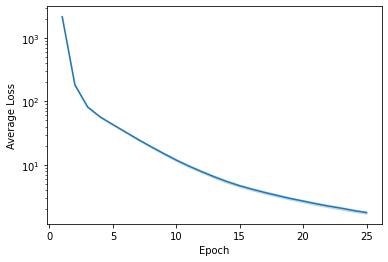

In [11]:
df = many_logs2pandas(getListOfFiles(log_base_dir))
losses = df.pivot(columns='metric', values='value').join(df.step)
losses["step"] = losses["step"] + 1
# Plot and save losses
ax = sns.lineplot(data = losses, x="step", y="epoch_loss")
ax.set_ylabel("Average Loss")
ax.set_xlabel("Epoch")
ax.set_yscale('log')
plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/regression/losses/losses_plot_{}.png".format(date_str), dpi = 200, bbox_inches = 'tight')
plt.show()

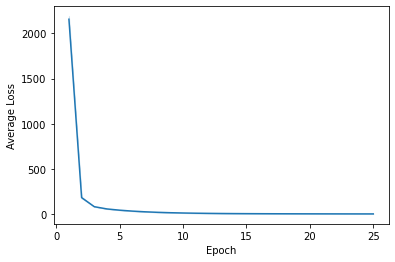

In [12]:
# Plot and save losses
ax = sns.lineplot(data = losses, x="step", y="epoch_loss")
ax.set_ylabel("Average Loss")
ax.set_xlabel("Epoch")
#plt.savefig("C:/repos/twrds_unbiased_anns/figures/results/regression/losses/losses_plot_{}.png".format(date_str), dpi = 200, bbox_inches = 'tight')
plt.show()